### Extract Coordinates from Gaussian Logs and Generate ECD GJF Files

This section processes Gaussian optimization output files (`.log`) to generate Gaussian input files (`.gjf`) for **Electronic Circular Dichroism (ECD)** calculations.

**Workflow Steps:**
1. Read `.log` files from the `opt_log/` directory
2. Extract atomic coordinates from the last "Standard orientation" block
3. Replace atomic numbers with element symbols (e.g., 6 → C)
4. Write properly formatted `.gjf` files with TD-DFT ECD calculation settings into the `ecd_gjf/` folder

> These `.gjf` files use `CAM-B3LYP/6-31G(d)` level of theory and request 20 excited states using `td=(nstates=20, root=20)`.

In [1]:

import pandas as pd
import numpy as np
import re
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

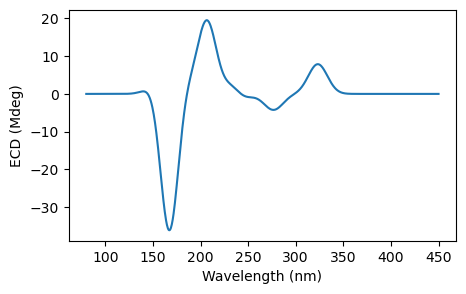

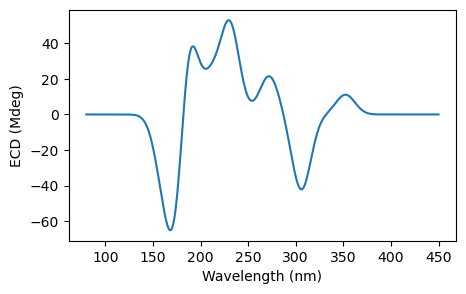

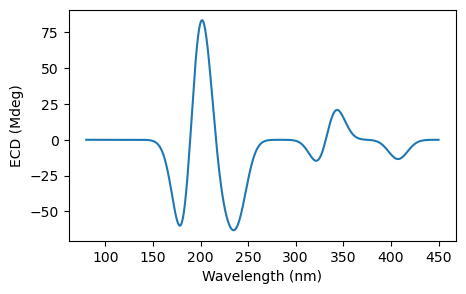

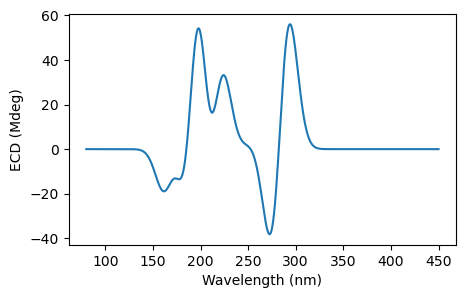

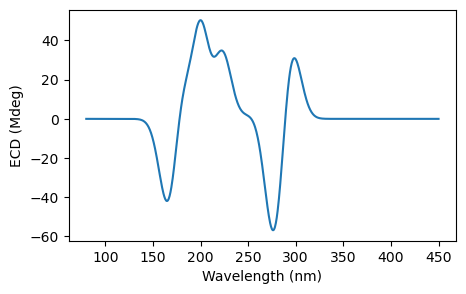

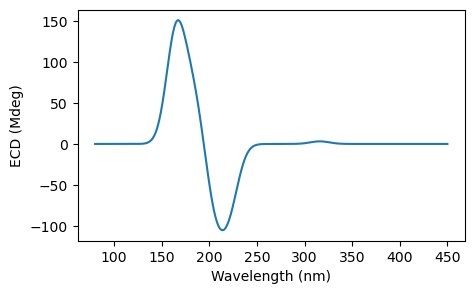

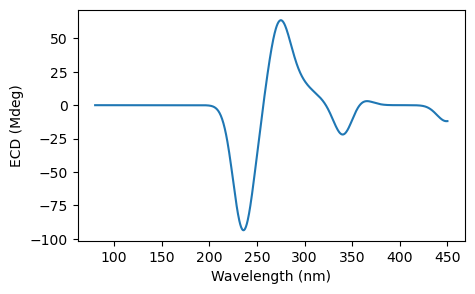

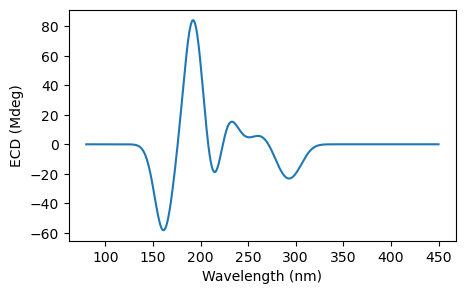

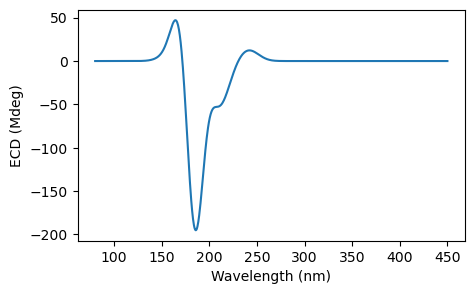

In [17]:
for i in range(1,10):
    # Read the file.
    with open('ecd_log\\molecule_'+str(i)+'_ECD.log', 'r') as f:
        content = f.read()
    # Use regular expressions to extract energy terms.
    pattern_1 = r'\d+\.\d+\s+eV\s+\d+\.\d+\s+nm\s+f=\d+\.\d+'
    matches_1 = re.findall(pattern_1, content)
    # Store key information in the form of a list.
    excitation_energies = []
    wavelength_sum = []
    #oscillator_strengths = []
    for match in matches_1:
        data = match.split()
        excitation_energy = float(data[0])
        wavelength = float(data[-3])
        #oscillator_strength = data[-1]
        wavelength_sum.append(wavelength)
        excitation_energies.append(excitation_energy)
        #oscillator_strengths.append(float(oscillator_strength.split('=')[1])) 
    
    # Read the file again.
    with open('ecd_log\\molecule_'+str(i)+'_ECD.log', 'r') as f:
        lines = f.readlines()
    # Use regular expressions to extract rotatory strengths (in the velocity representation) related to ECD spectrum generation R(velocity).
    pattern_2 = r'^\s*(\d+)\s+([-+]?\d+\.\d+)\s+([-+]?\d+\.\d+)\s+([-+]?\d+\.\d+)\s+([-+]?\d+\.\d+)\s+([-+]?\d+\.\d+)\s*$'
    # Store the rotatory strengths in a list format:R_values[40:60].
    R_values = []
    for line in lines:
        match = re.match(pattern_2, line)
        if match:
            R_value = float(match.group(5))
            R_values.append(R_value)
    # Perform Gaussian broadening based on the extracted energies and rotatory strengths.
    excitation_energies = np.array(excitation_energies)
    rotatory_strengths = np.array(R_values[40:60])
    wavelength_sum = np.array(wavelength_sum)
    #oscillator_strengths = np.array(oscillator_strengths)
    # Define the wavelength range as 80-450.
    excitation_energies_ext = np.concatenate([1240/np.array([15.5000]), 1240/excitation_energies, 1240/np.array([4.1333])])
    # Interpolate with equal spacing.
    x_interp = np.linspace(80, 450, 800)
    # Define the Gaussian function.
    def gaussian(x, center, width):
        return np.exp(-(x-center)**2/(2*width**2))
    # Substitute various parameters and perform broadening.
    ecd_spectrum = np.zeros(len(x_interp))
    for k in range(len(wavelength_sum)):
        center = wavelength_sum[k]
        width = 10 # 高斯展宽参数，可以自行调整
        amplitude = 1.5*rotatory_strengths[k]
        gaussian_i = gaussian(x_interp, center, width)
        #print(gaussian_i)
        ecd_spectrum += amplitude * gaussian_i
    # Plot the graph.
    plt.figure(figsize=(5, 3))
    plt.plot(x_interp, ecd_spectrum)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('ECD (Mdeg)')
    plt.show()